## 1. Open Exploartion

In this notebook, the outcomes of the "base case" policy ("do nothing policy") are explored. For the "base case" all policy levers are set to zero. This exploration is done to get an overview of the current situation and behaviour of the KPI's. 

Afterwards, the worst scenarios for our KPI's have been selected and analysed. Following from this analysis, we can define the uncertainty-ranges the model will act most worse in. Later on, these uncertainties will be given extra attention when finding the most robust policies.

For our experiments we will use the latin hypercube sampling (LHS) to generate the points in the parameter space defined by the uncertainties and 'base case' policy. 

In [1]:
# Import libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Import workbench libraries and the model itself
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import pairs_plotting, plotting
from ema_workbench.util import ema_logging, utilities
from ema_workbench import save_results
from ema_workbench import load_results

from problem_formulation_new import get_model_for_problem_formulation
from dike_model_function import DikeNetwork 

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

Here we define the problem formulation. For our analysis, we pick problem formulation 5, since pf 5 results in the most disaggregate form of the outcomes. Later on we aggregate the outcomes in the KPIs that are of most use to us.

In [2]:
# # Import case function
# #choose problem formulation number, between 0-5

# # 5 objectives PF
# dike_model, planning_steps = get_model_for_problem_formulation(5)

# def sum_over(*args):
#     return sum(args)

First we run a base exploration, with all policy levers set to zero. We chose to run for 5000 scenario's, as this will give an broad overview in which the full uncertainty space is more or less covered (relatively seen).

Some code is commented out, because it was run and afterwards saved to e.g. a CSV-file.

In [31]:
# # Define the base case policy, which sets all the levers that are present within the dike_model to zero.
# # do nothing bolicy
# policies = [Policy("base case", **{lever.name: 0 for lever in dike_model.levers})]

# #Running the experiments (commented out)
# with MultiprocessingEvaluator(dike_model, n_processes = 8) as evaluator:
#      results = evaluator.perform_experiments(scenarios=5000, policies=policies)

# utilities.save_results(results, 'results/5000_scenarios_base_case.csv')
# experiments, outcomes = results

# Load in the results from the CSV we had saved from running the experiments
results = utilities.load_results('results/5000_scenarios_base_case.csv')
experiments, outcomes = results

# We create a 'combined' dataframe, in which the experiments and outcomes are merged within one pandas dataframe.
df_outcomes = pd.DataFrame(outcomes)
combined = pd.concat([experiments,df_outcomes],axis=1,sort=False)

combined.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\ASUS\PycharmProjects\EPA1361\EPA1361_final\results\5000_scenarios_base_case.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,82.0,112.588522,10.0,0.060112,207.259283,10.0,0.681905,298.346650,10.0,0.204375,...,0,0.208533,0.000000e+00,0,0.000000,0.0,0,0.0,0.0,0.0
1,14.0,51.029922,1.0,0.277459,302.598285,1.5,0.960055,156.916590,10.0,0.004221,...,0,1.197254,0.000000e+00,0,0.000000,0.0,0,0.0,0.0,0.0
2,128.0,56.198749,1.5,0.880576,136.816986,10.0,0.344347,221.692894,10.0,0.175895,...,0,0.870198,0.000000e+00,0,0.000000,0.0,0,0.0,0.0,0.0
3,96.0,123.505345,1.5,0.797417,322.362756,1.5,0.977793,292.806136,10.0,0.765065,...,0,0.050221,2.064967e+07,0,0.011789,0.0,0,0.0,0.0,0.0
4,52.0,311.328249,10.0,0.433875,130.977495,1.0,0.646960,95.169589,10.0,0.962059,...,0,0.000000,3.580277e+07,0,0.018065,0.0,0,0.0,0.0,0.0


### Visualization of the retrieved outcomes ###

In order to acquire information from the experiment performed earlier, we visualize the retrieved data in a form that is readable and ready to communicate with our problem owner. 

To do so, we aggregated the outcomes from problem formulation 5 into our relevant KPIs. The following KPIs are considered: 
 - Expected number of deaths (total)
 - Expected annual damage (per province)
 - Dike Investment Costs (per province)
 - RfR Total Costs
 - Expected Evacuation Costs
 
Since the 'base case' policy does not consider any investment in the dikes and RfR, all of the costs-outcomes are zero and, therefore, are not taken into account within this visualization or further analysis for the base case.

In [30]:
# The following function is used to aggregate the outcomes into the KPI we want
# This iterates over all the locations and round numbers, and creates a new column summing the values per location and round.
# If we want to aggregate over the location, "aggregate" equals "location" and therefore the KPI is added per location and not in total.
# If we want to aggregate over the province, "aggregate" equals "name of the province" and therefore the KPI is added per province.
# On the contrary, if aggregate equals "total", the total value is appended to the dataframe.
def aggregate_kpi(data, kpi, aggregate):
    locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
    provinces = ["Overijssel", "Gelderland"]
    kpi_columns = []
    
    if kpi == "RfR Total Costs" or kpi == "Expected Evacuation Costs":
        kpi_columns.append(kpi + " 0")
        kpi_columns.append(kpi + " 1")
        kpi_columns.append(kpi + " 2")
        
        data[kpi] = data[kpi_columns].sum(axis=1)
    else:
        if aggregate == "total":
            for location in locations:
                kpi_columns.append(location + "_" + kpi + " 0")
                kpi_columns.append(location + "_" + kpi + " 1")
                kpi_columns.append(location + "_" + kpi + " 2")

            data[kpi] = data[kpi_columns].sum(axis=1)
            
        elif aggregate == "province":
            for province in provinces:
                if province == 'Overijssel':
                    kpi_columns = []
                    kpi_columns.append("A.4" + "_" + kpi + " 0")
                    kpi_columns.append("A.4" + "_" + kpi + " 1")
                    kpi_columns.append("A.4" + "_" + kpi + " 2")
                    kpi_columns.append("A.5" + "_" + kpi + " 0")
                    kpi_columns.append("A.5" + "_" + kpi + " 1")
                    kpi_columns.append("A.5" + "_" + kpi + " 2")                    
                    
                    data["Overijssel" + "_" + kpi] = data[kpi_columns].sum(axis=1)
      
           
                else:
                    kpi_columns = []
                    kpi_columns.append("A.1" + "_" + kpi + " 0")
                    kpi_columns.append("A.1" + "_" + kpi + " 1")
                    kpi_columns.append("A.1" + "_" + kpi + " 2")
                    kpi_columns.append("A.2" + "_" + kpi + " 0")
                    kpi_columns.append("A.2" + "_" + kpi + " 1")
                    kpi_columns.append("A.2" + "_" + kpi + " 2") 
                    kpi_columns.append("A.3" + "_" + kpi + " 0")
                    kpi_columns.append("A.3" + "_" + kpi + " 1")
                    kpi_columns.append("A.3" + "_" + kpi + " 2")                    

                    data["Gelderland" + "_" + kpi] = data[kpi_columns].sum(axis=1)
            
        else:
            for location in locations:
                kpi_columns = []
                kpi_columns.append(location + "_" + kpi + " 0")
                kpi_columns.append(location + "_" + kpi + " 1")
                kpi_columns.append(location + "_" + kpi + " 2")

                data[location + "_" + kpi] = data[kpi_columns].sum(axis=1)
                
    return data

In [45]:
# Append the KPIs we would like to analyse.
combined = aggregate_kpi(combined, "Expected Number of Deaths", "total")
combined = aggregate_kpi(combined, "RfR Total Costs", "total")
combined = aggregate_kpi(combined, "Expected Evacuation Costs", "total")
combined = aggregate_kpi(combined, "Expected Annual Damage", "province")
combined = aggregate_kpi(combined, "Dike Investment Costs", "province")

In [46]:
combined.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2,Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Overijssel_Expected Annual Damage,Gelderland_Expected Annual Damage,Overijssel_Dike Investment Costs,Gelderland_Dike Investment Costs
0,82.0,112.588522,10.0,0.060112,207.259283,10.0,0.681905,298.346650,10.0,0.204375,...,0.0,0.0,0.0,2.635901,0.0,0.0,0.000000e+00,2.318300e+09,0,0
1,14.0,51.029922,1.0,0.277459,302.598285,1.5,0.960055,156.916590,10.0,0.004221,...,0.0,0.0,0.0,5.630018,0.0,0.0,0.000000e+00,5.614819e+09,0,0
2,128.0,56.198749,1.5,0.880576,136.816986,10.0,0.344347,221.692894,10.0,0.175895,...,0.0,0.0,0.0,2.749357,0.0,0.0,0.000000e+00,1.419024e+09,0,0
3,96.0,123.505345,1.5,0.797417,322.362756,1.5,0.977793,292.806136,10.0,0.765065,...,0.0,0.0,0.0,0.193631,0.0,0.0,8.018833e+07,9.555533e+07,0,0
4,52.0,311.328249,10.0,0.433875,130.977495,1.0,0.646960,95.169589,10.0,0.962059,...,0.0,0.0,0.0,0.459794,0.0,0.0,1.298937e+08,5.898596e+08,0,0


First of all, the locations are to be analysed with the means of a violin-plot. The violin-plot indicates the distribution of the outcomes, i.e. the width indicates the frequency of outcomes in that particular range. 

**Expected number of deaths per location**

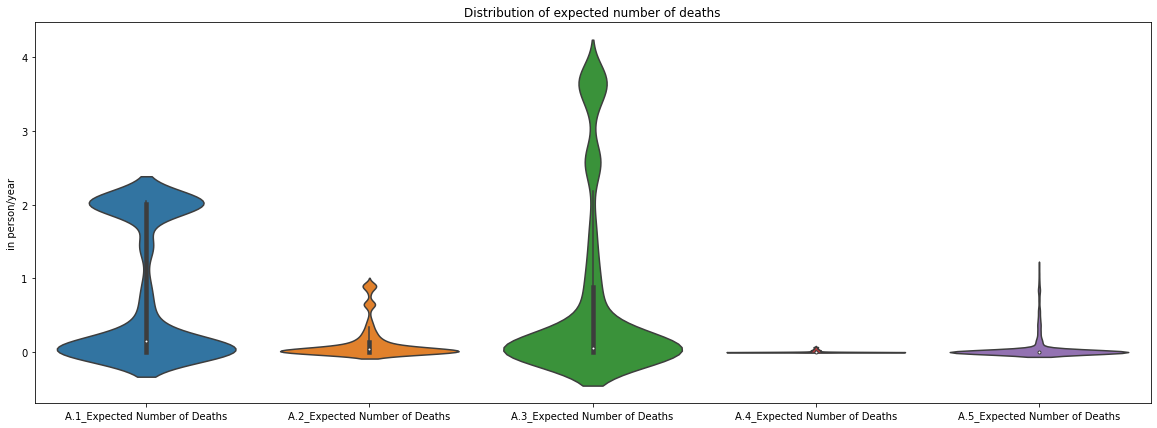

In [9]:
plt.figure(figsize=(20,7))
plt.title("Distribution of expected number of deaths")
plt.ylabel("in person/year")
ax = sns.violinplot(data=combined.loc[:, ["A.1_Expected Number of Deaths","A.2_Expected Number of Deaths","A.3_Expected Number of Deaths","A.4_Expected Number of Deaths","A.5_Expected Number of Deaths"]], scale='count')
plt.show()

**Expected annual damage per location**

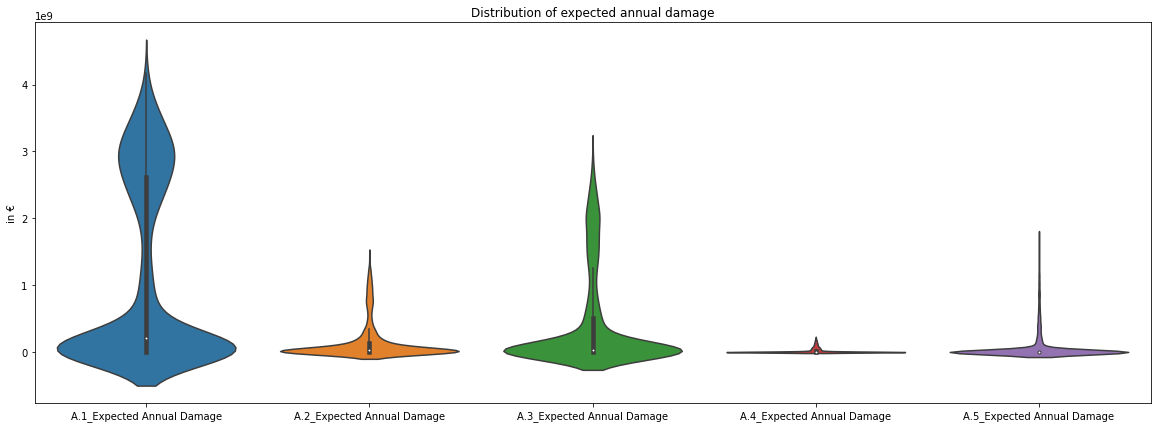

In [10]:
plt.figure(figsize=(20,7))
plt.title("Distribution of expected annual damage")
plt.ylabel("in €")
ax = sns.violinplot(data=combined.loc[:, ["A.1_Expected Annual Damage","A.2_Expected Annual Damage","A.3_Expected Annual Damage","A.4_Expected Annual Damage","A.5_Expected Annual Damage"]], scale='count')
plt.show()

As can be seen in the figures above, location A1 and A3 suffers the most in the 'base case' policy scenarios. The 'expected number of deaths' and the 'expected annual damage' is in those locations the highest of all 5. Also, it can be noted that within these locations the amount of outliers are higher comparing to the other 3 locations.

**Cost per province**
